In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.io as sio
import os
from os import listdir
from numpy import asarray
from numpy import save
import shutil
import math

import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from keras.models import load_model
from keras.models import Sequential

from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import *

from sklearn.model_selection import train_test_split


from PIL import Image
import tensorflow as tf
import cv2

from matplotlib import pyplot
from matplotlib.image import imread

Using TensorFlow backend.


In [2]:
data = pd.read_csv('results.csv')

In [3]:
value_counts = data['Gender'].value_counts()
print(value_counts)

0    84
1    32
Name: Gender, dtype: int64


In [4]:
train_male = int(round(value_counts[0]*0.7))
train_female = int(round(value_counts[1]*0.7))
test_male =value_counts[0]-train_male
test_female = value_counts[1] -train_female
print("train_male:{}, train_female:{} and train_total:{}\ntest_male:{}, test_female:{} and test_total:{}"
      .format(
          train_male,
          train_female,
          train_male+train_female,
          test_male,test_female,
          test_male+test_female
      ))

train_male:59, train_female:22 and train_total:81
test_male:25, test_female:10 and test_total:35


In [5]:
train_male_data = data[data['Gender'] == 0][:train_male]
test_male_data = data[data['Gender'] ==0][train_male:]
train_female_data = data[data['Gender'] == 1][:train_female]
test_female_data = data[data['Gender'] ==1][train_female:]
train_data = pd.concat([train_male_data,train_female_data])
test_data = pd.concat([test_male_data,test_female_data])

In [6]:
train_data = train_data[['Filename','Gender']]
test_data = test_data[['Filename','Gender']]

In [7]:
train_dict = dict(zip(train_data['Filename'], train_data['Gender']))
test_dict = dict(zip(test_data['Filename'], test_data['Gender']))

In [8]:
train_data.head()

,Filename,Gender
2,Raw_0003_003_20050913094955_Portrait.png,0
4,Raw_0007_005_20050913093707_Portrait.png,0
5,Raw_0009_006_20050913122608_Portrait.png,0
6,Raw_0010_007_20050913094809_Portrait.png,0
7,Raw_0011_008_20050913123954_Portrait.png,0


In [9]:
train_dirName = 'final/train'
test_dirName = 'final/test'
if not os.path.exists(train_dirName):
    os.mkdir(train_dirName)
if not os.path.exists(test_dirName):
    os.mkdir(test_dirName)
for i,v in train_data['Filename'].iteritems():
    shutil.copy2('final/'+v, 'final/train/'+v)
for i,v in test_data['Filename'].iteritems():
    shutil.copy2('final/'+v, 'final/test/'+v)

In [10]:
nine_images = enumerate(train_data['Filename'][:9].iteritems())
print(list(nine_images))

[(0, (2, 'Raw_0003_003_20050913094955_Portrait.png')), (1, (4, 'Raw_0007_005_20050913093707_Portrait.png')), (2, (5, 'Raw_0009_006_20050913122608_Portrait.png')), (3, (6, 'Raw_0010_007_20050913094809_Portrait.png')), (4, (7, 'Raw_0011_008_20050913123954_Portrait.png')), (5, (8, 'Raw_0012_009_20050913095944_Portrait.png')), (6, (10, 'Raw_0016_011_20050913100034_Portrait.png')), (7, (11, 'Raw_0018_012_20050913095525_Portrait.png')), (8, (12, 'Raw_0020_013_20050913093233_Portrait.png'))]


In [11]:
%matplotlib inline

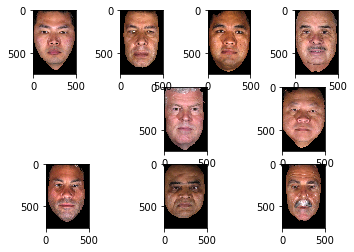

In [12]:
# define location of dataset
folder = 'final/'
# plot first few images
for i,v in train_data['Filename'][:10].iteritems():
    # define subplot
    pyplot.subplot(331+i)
    # define filename
    filename = folder + str(v)
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

In [13]:
# define location of dataset
#folder = 'final/train/'
#photos, labels = list(), list()
# enumerate files in the directory
#for file in listdir(folder):
#    # determine class
#    output = train_dict[file]
#    # load image
#    photo = load_img(folder + file, target_size=(200, 200))
#    # convert to numpy array
#    photo = img_to_array(photo)
#    # store
#    photos.append(photo)
#    labels.append(output)
## convert to a numpy arrays
#photos = asarray(photos)
#labels = asarray(labels)
#print(photos.shape, labels.shape)
## save the reshaped photos
#save('male_and_female_photos.npy', photos)
#save('male_and_female_labels.npy', labels)

In [14]:
# load and confirm the shape
from numpy import load
photos = load('male_and_female_photos.npy')
labels = load('male_and_female_labels.npy')
print(photos.shape, labels.shape)

(82, 200, 200, 3) (82,)


In [15]:
# create directories
dataset_home = 'final/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['male/', 'female/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        os.mkdir(newdir)

In [16]:
for i,v in train_data['Filename'].iteritems():
    if train_dict[v] == 0:
        shutil.copy2('final/train/'+v, 'final/train/male/'+v)
    else:
        shutil.copy2('final/train/'+v, 'final/train/female/'+v)
for i,v in test_data['Filename'].iteritems():
    if test_dict[v] == 0:
        shutil.copy2('final/test/'+v, 'final/test/male/'+v)
    else:
        shutil.copy2('final/test/'+v, 'final/test/female/'+v)

In [17]:
model = Sequential()
# block 1
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
model.add(MaxPooling2D((2, 2)))
# block 2
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
#block 3
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))
# compile model
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 160000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               20480128  
_________________________________________________________________
dens

In [18]:
# create data generator
datagen = ImageDataGenerator(rescale=1.0/255.0)
# prepare iterators
train_it = datagen.flow_from_directory('final/train/',
    class_mode='binary', batch_size=8, target_size=(200, 200))
test_it = datagen.flow_from_directory('final/test/',
    class_mode='binary', batch_size=8, target_size=(200, 200))

Found 81 images belonging to 2 classes.
Found 35 images belonging to 2 classes.


In [19]:
# fit model
history = model.fit_generator(train_it,
                              steps_per_epoch=len(train_it),
                              validation_data=test_it,
                              validation_steps=len(test_it),
                              epochs=20,
                              verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
11/11 [==============================] - 20s 2s/step - loss: 1.0462 - acc: 0.5036 - val_loss: 0.5335 - val_acc: 0.7143
Epoch 2/20
11/11 [==============================] - 16s 1s/step - loss: 0.5517 - acc: 0.8054 - val_loss: 0.6293 - val_acc: 0.6286
Epoch 3/20
11/11 [==============================] - 15s 1s/step - loss: 0.4598 - acc: 0.8627 - val_loss: 0.4721 - val_acc: 0.8286
Epoch 4/20
11/11 [==============================] - 15s 1s/step - loss: 0.3322 - acc: 0.9084 - val_loss: 0.4524 - val_acc: 0.8571
Epoch 5/20
11/11 [==============================] - 17s 2s/step - loss: 0.2796 - acc: 0.8970 - val_loss: 0.5903 - val_acc: 0.7143
Epoch 6/20
11/11 [==============================] - 16s 1s/step - loss: 0.2698 - acc: 0.8970 - val_loss: 0.4743 - val_acc: 0.8000
Epoch 7/20
11/11 [==============================] - 15s 1s/step - loss: 0.2747 - acc: 0.8470 - val_loss: 0.6741 - val_acc: 0.6857
Epoch 8/20
11/11 [========================

In [20]:
# evaluate model
_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))

> 85.714


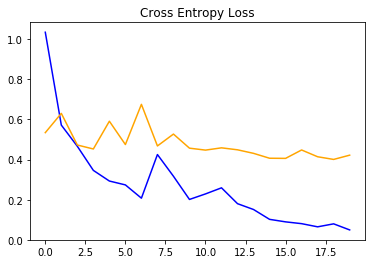

In [21]:
# plot loss
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')
pyplot.savefig('Cross Entropy Loss.png')
pyplot.show()

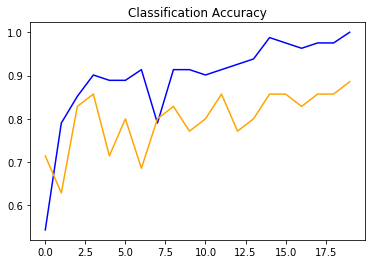

In [22]:
# plot accuracy
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['acc'], color='blue', label='train')
pyplot.plot(history.history['val_acc'], color='orange', label='test')
pyplot.savefig('Classification Accuracy.png')
pyplot.show()